## lib Loading

In [843]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [844]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from si_prefix import si_format

## Grand plans

### Junction project

- Fab SQUID chain with $E_J 200mK, E_C 8mK$ **(Q1D078)**
- Fab  SQUID chain with $E_J 4K, E_C 8mK$ to study $E_J$ cross-over **(Q1D074_N4)**
- Study noise reduction
    - better V source
    - better filters
        - Commercial LP filters
        - Add $1M\Omega$ metal film resistor on sample holder
    - Check noise spectrum with low $f$ range oscilloscope 

### Bi-fluxon project

grAl bi-fluxon with $5 \times 25\mu m^2, \mu H$ level superinductor

### HIM project

- Complete $T_C$-dome for grAl before / after $He^{+}$ irradiation

<IPython.core.display.Javascript object>


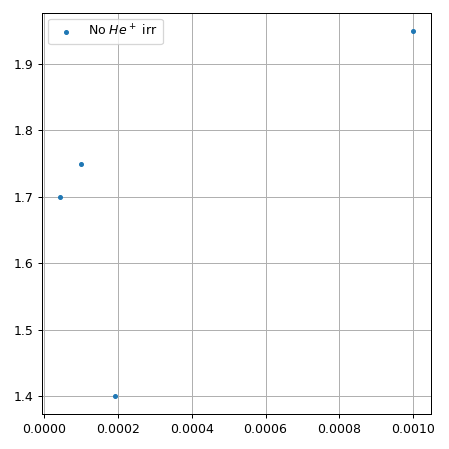

In [105]:
Tc  = [     1.4,    1.7,   1.75,   1.95,     ]
rho = [ 19.2e-5, 4.2e-5, 9.9e-5, 100e-5,     ]

plt.close('all')
f,ax = plt.subplots(figsize=(5, 5))
ax.plot(rho,Tc,'.', label='No $He^+$ irr')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


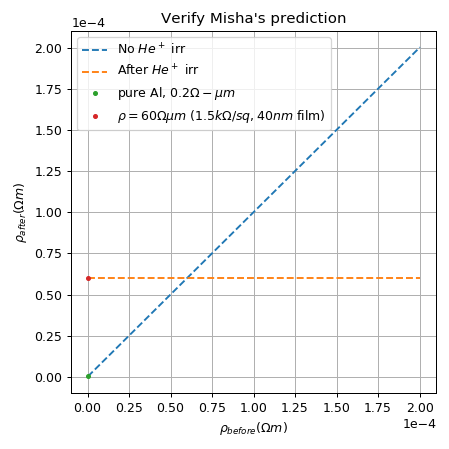

In [88]:
x = np.linspace(0.2e-6, 200.2e-6, 201)
y_bf = x
y_pure = 0.2e-6
y_amor =  60e-6
y_af = np.full(201, y_amor)

plt.close('all')
f,ax = plt.subplots(figsize=(5, 5))
ax.plot(x,y_bf,ls='--', label='No $He^+$ irr')
ax.plot(x,y_af,ls='--', label='After $He^+$ irr')
ax.plot(y_pure,y_pure, '.', label='pure Al, $0.2\Omega-\mu m$')
ax.plot(y_pure,y_amor, '.', label=r'$\rho = 60\Omega\mu m$ ($1.5k\Omega/sq,40nm$ film)')
ax.title.set_text('Verify Misha\'s prediction')
ax.set_xlabel(r'$\rho_{before} (\Omega m)$')
ax.set_ylabel(r'$\rho_{after} (\Omega m)$')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## To Do list
- LS370 still crashes after around 7hrs continuous operation
- Make new cables
    - Remake the I, V splitting Fisher probing line
    - Remake ISO, COM x2 Fisher-BNC cables
- Maintain old sample holder
    - Fix pin 5b
- Try to see if we can fix the wiring in the fridge. Currently ch 5ab open, ch 10ab short.
- Make new sample holder

## Update RTc for T8>102K

Locate files "CH8 T dd-mm-yy.log" and "CH0 T dd-mm-yy.log" under below path:

C:\Users\KelvinOX25\Documents\GitHub\measDC

Copy them to below path:

\\SERIN135_DR-PC\BlueFors\Temperature Log\dd-mm-yy

Then run below two cells

In [3]:
import time, datetime

def getTt(rootpath, filedate = '21-11-19', Tch = 0):
    filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
    filepath = rootpath+filename

    dateori = datetime.datetime(2019,11,21,0,0,0)
    dhrslst = []
    dlst = []
    Tlst = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            l = line.strip()
            d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                                  int(l.split(',')[0].split('-')[1]),
                                  int(l.split(',')[0].split('-')[0]),
                                  int(l.split(',')[1].split(':')[0]),
                                  int(l.split(',')[1].split(':')[1]),
                                  int(l.split(',')[1].split(':')[2]))
            T = float(l.split(',')[2])
            dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
            dlst.append(d)
            Tlst.append(T)
            line = fp.readline()
            cnt += 1
    fp.close()
    return (dhrslst, dlst, Tlst)

def fillDataGap(ref_x1, gapped_x2, gapped_y2):
    filled_y2 = np.full_like(np.arange(len(ref_x1)),np.nan, dtype=np.double)
    for i,v2 in enumerate(gapped_x2):
        for j,v1 in enumerate(ref_x1):
            vt1 = v1.year*525600 + v1.month*43800 + v1.day*1440 + v1.hour*60 + v1.minute
            vt2 = v2.year*525600 + v2.month*43800 + v2.day*1440 + v2.hour*60 + v2.minute
            if vt2 == vt1:
                filled_y2[j]= gapped_y2[i]
                break
    return filled_y2

<IPython.core.display.Javascript object>


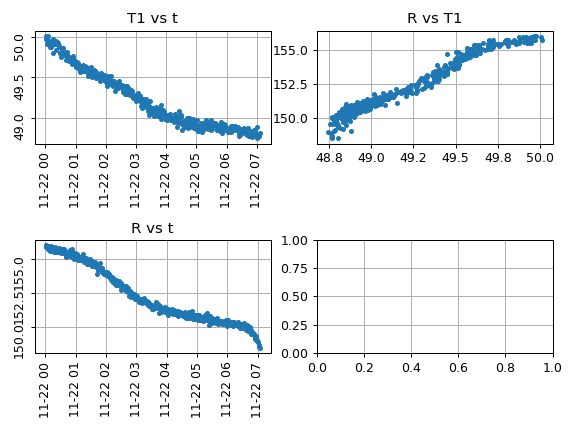

In [20]:
rootpath = r'\\SERIN135_DR-PC\BlueFors\Temperature Log'
filedate = '22-11-19'
dhrslst1, dlst1, Tlst1 = getTt(rootpath=rootpath, filedate = filedate, Tch = 1)
dhrslstR, dlstR, TlstR = getTt(rootpath=rootpath, filedate = filedate, Tch = 0)

TlstRnew = fillDataGap(ref_x1 = dlst1, gapped_x2 = dlstR, gapped_y2 = TlstR)
plt.close('all')
f,ax = plt.subplots(2,2)
ax[0][0].plot(dlst1,Tlst1,'.')
ax[0][0].set_title('T1 vs t')
ax[0][0].tick_params(labelrotation=90)

ax[1][0].plot(dlstR,TlstR,'.')
ax[1][0].set_title('R vs t')
ax[1][0].tick_params(labelrotation=90)

ax[0][1].plot(Tlst1,TlstRnew,'.')
from matplotlib.ticker import FormatStrFormatter
ax[0][1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0][1].set_title('R vs T1')


for i in [0,1]:
    for j in [0,1]:
        ax[i][j].grid()

plt.tight_layout()
plt.show()

## Realtime data visualization

In [2]:
import qcodes as qc
from qcodes.dataset.database import initialise_database
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'
